In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/uware/rosbags/static/translation/36h11_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.293408
1,0.645031,2.197257
2,1.133312,2.107797
3,1.577328,2.051728
4,1.919092,2.047748
...,...,...
903,95.522515,7.842079
904,95.625760,7.827373
905,95.721238,7.845251
906,95.819824,8.030762


<AxesSubplot:xlabel='relative_time'>

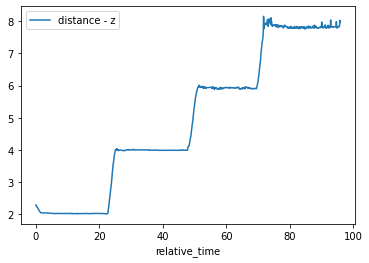

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .075)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

210

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

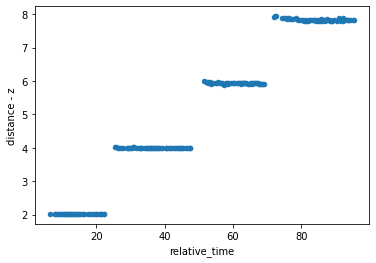

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
12,6.322620,2.030417,2
16,7.805617,2.031036,2
18,7.990911,2.027864,2
20,8.183770,2.027950,2
24,8.593316,2.032271,2
...,...,...,...
885,93.724363,7.832724,8
887,93.921724,7.826495,8
891,94.322047,7.829823,8
900,95.219998,7.827124,8


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
12,6.322620,2.030417,2,-0.030417
16,7.805617,2.031036,2,-0.031036
194,25.421928,4.029332,4,-0.029332
196,25.615458,4.041391,4,-0.041391
459,51.451532,6.013810,6,-0.013810
465,52.054146,5.972434,6,0.027566
668,72.091926,7.915484,8,0.084516
671,72.387149,7.938168,8,0.061832


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,40.0,-0.028615,0.002679,-0.032504,-0.030656,-0.028837,-0.027718,-0.020676
4,57.0,-0.000805,0.009213,-0.041391,-0.005578,0.001560,0.005493,0.011998
6,55.0,0.062367,0.021585,-0.013810,0.053194,0.060847,0.076347,0.108396
8,58.0,0.161502,0.035941,0.061832,0.141740,0.167391,0.187633,0.211818


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

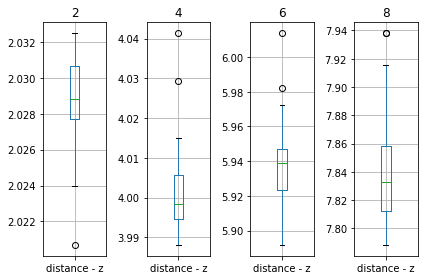

In [16]:
box_plotter(target)

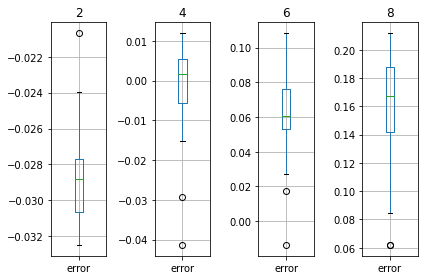

In [17]:
box_plotter('error')